# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data_wrangling.csv',parse_dates=['InvoiceDate'])
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,ItemTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


## Data Visualization

In [3]:
# remove transactions with price equals to 0
df = df[df['Price'] != 0]

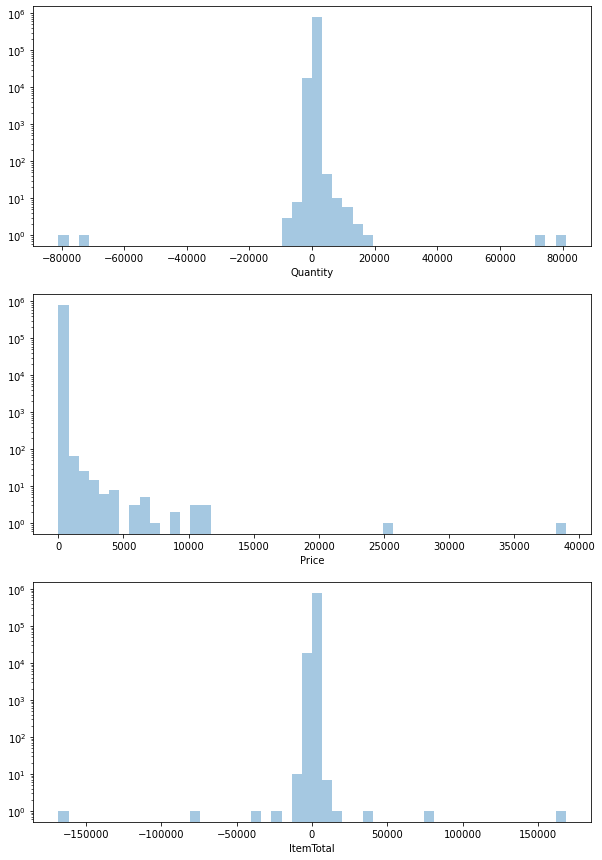

In [4]:
# histograms for quantity, price, and item total columns
fig, axs = plt.subplots(3,1,figsize=(10,15))

sns.distplot(df.Quantity,kde=False,ax=axs[0])
axs[0].set_yscale('log')

sns.distplot(df.Price,kde=False,ax=axs[1])
axs[1].set_yscale('log')

sns.distplot(df.ItemTotal,kde=False,ax=axs[2])
axs[2].set_yscale('log')

plt.show()

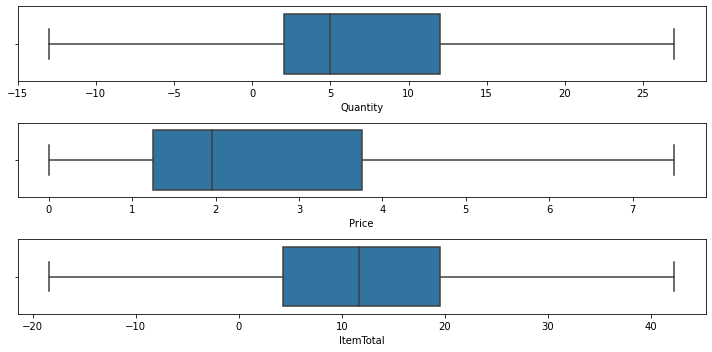

In [5]:
# box plots for quantity, price, and item total columns, without outliers
fig, axes = plt.subplots(3,1,figsize=(10,5))

sns.boxplot(x='Quantity', data=df, ax=axes[0], showfliers=False)
sns.boxplot(x='Price', data=df, ax=axes[1], showfliers=False)
sns.boxplot(x='ItemTotal', data=df, ax=axes[2], showfliers=False)

plt.tight_layout()
plt.show()

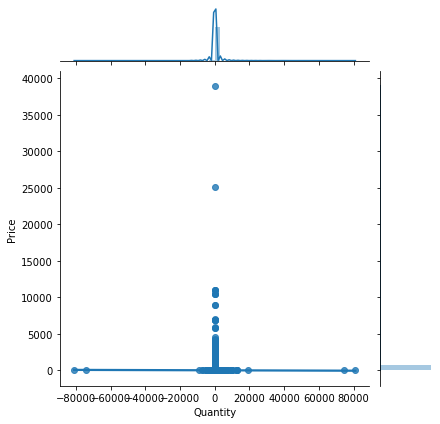

In [6]:
#create a jointplot
sns.jointplot(x='Quantity', y='Price', data=df, kind='reg')

In [7]:
# select numeric columns as a dataframe
nume_cols = df[['Quantity','Price','ItemTotal']]

Text(0.5, 1.0, 'Feature Correlation Heatmap')

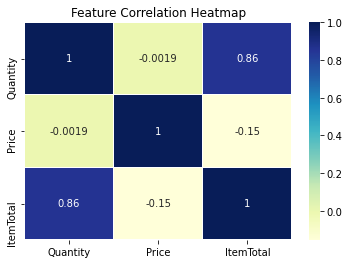

In [8]:
#create a feature correlation matrix heatmap
correlation = nume_cols.corr()
sns.heatmap(correlation, annot=True, linewidth=0.1, cmap='YlGnBu')
plt.title('Feature Correlation Heatmap')

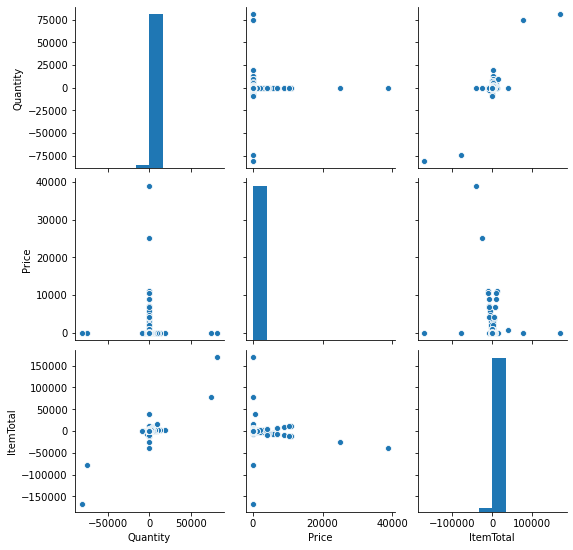

In [9]:
#create a pairplot
sns.pairplot(nume_cols)

In [10]:
# calculate order total for each order
orders = pd.DataFrame(df.groupby(['Invoice','Country','CustomerID']).ItemTotal.sum().reset_index())
orders.rename({'ItemTotal':'OrderTotal'},axis=1,inplace=True)
orders.head()

# remove orders with negative order values
# orders = orders[orders['OrderTotal'] >= 0]

,Invoice,Country,CustomerID,OrderTotal
0,489434,United Kingdom,13085,505.30
1,489435,United Kingdom,13085,145.80
2,489436,United Kingdom,13078,630.33
3,489437,United Kingdom,15362,310.75
4,489438,United Kingdom,18102,2286.24


Text(0, 0.5, 'Count')

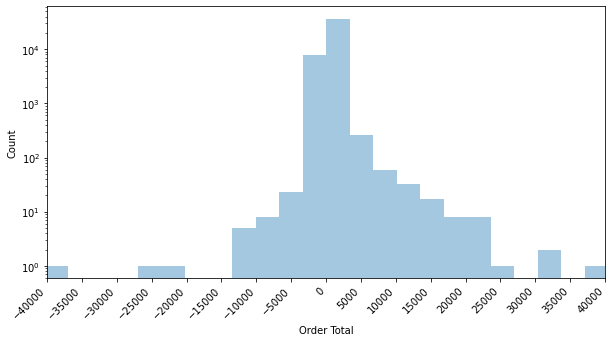

In [11]:
# plot a histogram for order total
plt.figure(figsize=(10,5))
sns.distplot(orders.OrderTotal,kde=False,bins=100)
plt.yscale('log')
plt.xlim(-40000,40000)
plt.xticks(np.arange(-40000,40001,5000),rotation=45,ha='right')
plt.xlabel('Order Total')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

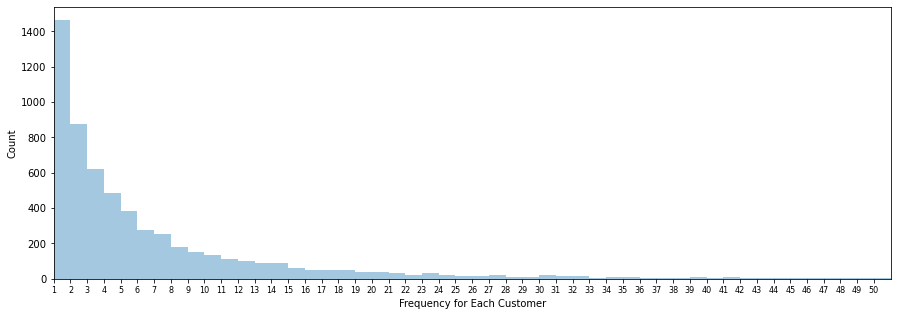

In [12]:
# calculate frequency for each customer
frequency = orders['CustomerID'].value_counts().rename('Frequency')

# plot a histogram
plt.figure(figsize=(15,5))
sns.distplot(frequency,bins=np.arange(1,500,1),kde=False)
plt.xlim(1,51)
plt.xticks(np.arange(1,51,1),fontsize=8)
plt.xlabel('Frequency for Each Customer')
plt.ylabel('Count')

In [13]:
# top 10 countries sorted by number of orders
countries = orders['Country'].value_counts().head(10).index

# select orders from the top 10 countries only
orders_top_coun = orders[orders['Country'].isin(countries)]

# calculate average order value for each country
country_average = pd.DataFrame(orders_top_coun.groupby('Country').OrderTotal.mean().rename('AverageOrder'))
country_average.sort_values('AverageOrder',ascending=False,inplace=True)
country_average

,AverageOrder
Country,
Netherlands,2287.851681
Australia,1446.583913
EIRE,788.906135
Sweden,712.313390
Spain,460.929832
France,414.197566
Portugal,387.154034
Germany,353.198452
United Kingdom,333.392068


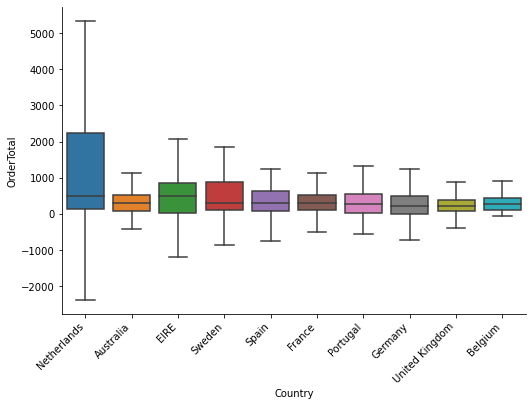

In [14]:
#create boxplots for order value for each country, sorted by the country average order value
sns.catplot(x='Country', y='OrderTotal', data=orders_top_coun, kind='box', showfliers=False, 
            height=5, aspect=1.5, order=country_average.index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [15]:
# calculate LTV for each customer
customer_ltv = pd.DataFrame(orders.groupby(['CustomerID','Country']).OrderTotal.sum().rename('LTV')).reset_index(level='Country')

# merge customer LTV and frequency
customer_ltv = customer_ltv.merge(frequency,left_index=True,right_index=True)
customer_ltv.head()

,Country,LTV,Frequency
12346,United Kingdom,-250.74,7
12347,Iceland,4921.53,8
12348,Finland,1658.40,5
12349,Italy,3654.54,4
12350,Norway,294.40,1


(0.0, 60000.0)

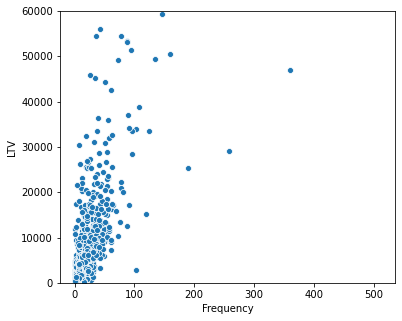

In [16]:
# scatter plot of frequency vs LTV
plt.figure(figsize=(6,5))
sns.scatterplot('Frequency','LTV',data=customer_ltv)
plt.ylim(0,60000)

In [17]:
# top 10 countries sorted by number of customers
countries = customer_ltv['Country'].value_counts().head(10).index
countries

Index(['United Kingdom', 'Germany', 'France', 'Spain', 'Belgium', 'Portugal',
       'Netherlands', 'Switzerland', 'Sweden', 'Italy'],
      dtype='object')

In [18]:
# select customers from the top 10 countries only
customer_ltv = customer_ltv[(customer_ltv['Country'].isin(countries)) & (customer_ltv['LTV'] >= 0)]

# calculate the average customer LTV for each country
country_average = pd.DataFrame(customer_ltv.groupby('Country').LTV.mean().rename('AverageLTV'))
country_average.sort_values('AverageLTV',ascending=False,inplace=True)
country_average

,AverageLTV
Country,
Netherlands,24751.230909
Sweden,4423.841053
Switzerland,4195.200455
Germany,3495.674402
France,3117.381684
United Kingdom,2544.191925
Spain,2068.411000
Belgium,1951.685862
Portugal,1919.638750


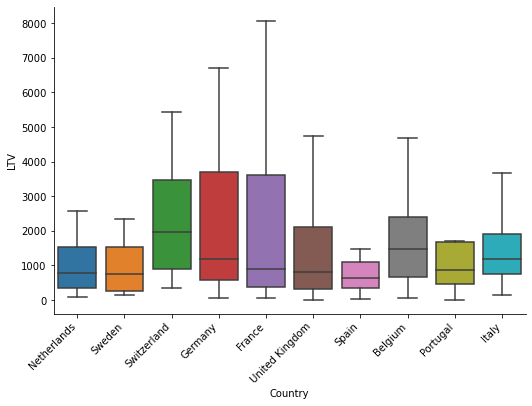

In [19]:
#create boxplots for customer LTV for each country, sorted by the country average customer LTV
sns.catplot(x='Country', y='LTV', data=customer_ltv, kind='box', showfliers=False,
            height=5, aspect=1.5, order=country_average.index)
plt.xticks(rotation=45, ha='right')
plt.show()

## Hypothesis Testing

From the analysis above we can see that UK and Germany are the top 2 countries where most of the customers are located, and we are interested in the difference between the average customer LTVs of these two countries.

In [20]:
# calculate the difference in average customer LTVs between UK and Germany
country_average = country_average.reset_index()
UKMean = country_average.loc[country_average['Country']=='United Kingdom', 'AverageLTV'].values[0]
GermanyMean = country_average.loc[country_average['Country']=='Germany', 'AverageLTV'].values[0]
MeanDiff = round(GermanyMean-UKMean)
MeanDiff

951.0

From the dataset, the average customer LTV for Germany is £951 higher than that of UK. We will select 5% as the significance level α and use two methods: **bootstrapping** and **t-test**, to test our hypothesis:

**H<sub>0</sub>: UK and Germany have the same average customer LTV  
H<sub>1</sub>: UK and Germany have different average customer LTVs**

### Bootstrap Method

In [21]:
# calculate the average customer LTV for UK and Germany together
Mean = round(customer_ltv[customer_ltv['Country'].str.contains('United Kingdom|Germany')].LTV.mean())
Mean

2563

In [22]:
# create customer LTV series for UK and Germany
uk = customer_ltv[customer_ltv['Country'] == 'United Kingdom'].LTV
germany = customer_ltv[customer_ltv['Country'] == 'Germany'].LTV

# shift the series so they have the same average customer LTV
uk_shifted = uk - UKMean + Mean
germany_shifted = germany - GermanyMean + Mean

In [23]:
# create a Bootstrap function to draw bootstrap replicates
def Bootstrap(data, func, size=1):

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(bs_sample)

    return bs_replicates

In [24]:
# create bootstrap replicates for UK average customer LTV
uk_bs = Bootstrap(uk_shifted, np.mean, size=10000)
uk_bs

array([2409.1271353 , 2300.00902665, 2472.20189022, ..., 2470.46710321,
       2665.30410509, 2707.54219497])

In [25]:
# create bootstrap replicates for Germany average customer LTV
germany_bs = Bootstrap(germany_shifted, np.mean, size=10000)
germany_bs

array([3443.76774766, 2317.58672897, 2626.35914953, ..., 2259.84971028,
       2603.15419626, 2709.70064486])

In [26]:
# calculate the difference between UK and Germany average customer LTVs
bs_replicates = germany_bs - uk_bs
bs_replicates

array([1034.64061237,   17.57770233,  154.15725931, ..., -210.61739293,
        -62.14990882,    2.15844989])

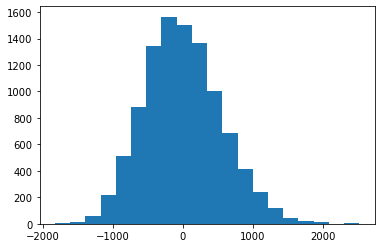

In [27]:
# check the distribution of the bootstrap replicates
plt.hist(bs_replicates,bins=20)
plt.show()

In [28]:
# calculate p-value
p = np.sum(abs(bs_replicates) >= MeanDiff) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0808


**The p value from the bootstrap test is not statistically significant to reject the null hypothesis that UK and Germany have the same average customer LTV.**

### t-test Method

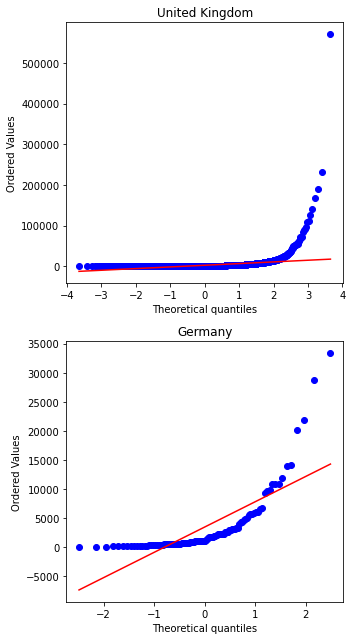

In [29]:
from scipy.stats import probplot

# create q-q plots for UK and Germany customer LTVs to check normality
plt.figure(figsize=(5,9))

plt.subplot(2,1,1)
probplot(uk,plot=plt)
plt.title('United Kingdom')

plt.subplot(2,1,2)
probplot(germany,plot=plt)
plt.title('Germany')

plt.tight_layout()
plt.show()

**From the Q-Q plots we can see that customer LTVs for UK and Germany are not normally distributed, but since the sample sizes are large enough for both countries, we can still use the t-test here.**

In [30]:
from scipy import stats

# t-test for two means, specify unequal variances
t, p = stats.ttest_ind(uk, germany, equal_var = False)

print('p-value =', p)

p-value = 0.09152075924367362


**The p value from the t-test is not statistically significant to reject the null hypothesis that UK and Germany have the same average customer LTV.**